### Assignment 5

![image info](https://www.mdpi.com/sensors/sensors-17-01951/article_deploy/html/images/sensors-17-01951-g003.png)


>SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size
(https://arxiv.org/abs/1602.07360)

In this assigment you're going to use the pretrained network SqueezeNetv1.2 (~ 5 Mb) 

#### Task 1 (5 points):

go to https://github.com/miaow1988/SqueezeNet_v1.2 and download the 'symbol.json' and '.params' files (there is not a 'synset.txt' file! so don't use these lines, Hint: just comment these lines).

* Install MXNet v1.5 (hint: create a new conda environmet with python 3, pip install mxnet==1.5.1) and follow the same steps of the lecture (part: *Using pre-trained models as feature extractors*). Find the flatten output layer and create a feature extractor (hint: It should be a numpy array of 1000 elements).
* Download the dogs versus cats *training folder* from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data (Remember the number of images is 12500 for each class).
* Extract the array of features for different number of images (N: 10, 100, 500, 1000, also 5000 and 12500) and for each value train your favorite binary classifier (only one!!!) using GridSearch to optimize some hyperparameters. Consider to use https://notebooks.csc.fi if you have computational limitations. 

* Report the accuracy for each value of N and the computational time during the training step.

#### Task 2 (5 points):

Repeat all previous steps using MobileNet V2 (https://github.com/KeyKy/mobilenet-mxnet). How the two networks compare in terms of accuracy and running time?

**WARNING**: At least for N= 5000 and 12500 it can take some time in your computer, depending of your resources. The time can largely increases depending of your chosen classifier.

#### Task 3 (5 points):

Using the best network. Train a machine learning model able to predic COVID-19 from chest X-Ray images. Use the data from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset. 

Present and discuss your best model.


----------------------------------------------------------

Before executing this notebook the following files and folders should be present 
in the same directory:

- train (folder containing all the 25,000 images of cats and dogs to be trained)
- model-symbol.json (SqueezeNet V2 pre-trained model file)
- model-0000.params (SqueezeNet V2 parameters file)
- mobilenet_v2-symbol.json (mobilenet v2 pre-trained model file)
- mobilenet_v2.0000.params (mobilenet v2 parameters file )
- train2 (folder containing the x-ray chest images for training)
- test2 (folder containing the x-ray chest images for testing)
- Chest_xray_Corona_Metadata.csv (The chest x-ray csv file)

Please Note: This ipynb ran in notebooks.csc.fi


# Task 1

Use SqueezeNet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import time

In [2]:
pip --version

pip 20.0.2 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install mxnet==1.5.1
#!pip install mxnet --user --no-warn-script-location

     |████████████████████████████████| 23.1 MB 4.2 MB/s eta 0:00:01:06           | 4.7 MB 4.2 MB/s eta 0:00:0500:04��██████▉                    | 8.5 MB 4.2 MB/s eta 0:00:04�▍                | 11.1 MB 4.2 MB/s eta 0:00:03██████████▋             | 13.5 MB 4.2 MB/s eta 0:00:03█████████████████████           | 15.2 MB 4.2 MB/s eta 0:00:02█████████████▌        | 17.0 MB 4.2 MB/s eta 0:00:02��████████████████████▎     | 19.0 MB 4.2 MB/s eta 0:00:01�███████████▌   | 20.6 MB 4.2 MB/s eta 0:00:01███████████████▌| 22.8 MB 4.2 MB/s eta 0:00:01
  Attempting uninstall: mxnet
    Found existing installation: mxnet 1.8.0.post0
    Uninstalling mxnet-1.8.0.post0:
      Successfully uninstalled mxnet-1.8.0.post0


In [12]:
!pip install requests matplotlib opencv-python-headless

In [13]:
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint('model', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
#with open('synset.txt', 'r') as f:
#    labels = [l.rstrip() for l in f]

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    #fname = mx.test_utils.download(url)
    fname = url
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

NameError: name 'labels' is not defined

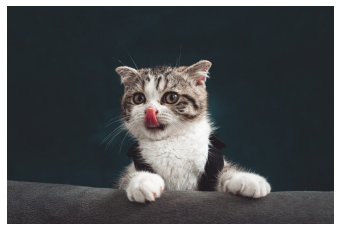

In [16]:
#predict('https://cdn.pixabay.com/photo/2021/10/19/10/56/cat-6723256_960_720.jpg')
predict('cat-6723256_960_720.jpg')


FEATURE EXTRACTION

In [17]:
# list the last 10 layers

all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'dropout0_output',
 'conv10_conv_weight',
 'conv10_conv_bias',
 'conv10_conv_output',
 'conv10_relu_output',
 'pool10_output',
 'flatten0_output',
 'softmax_label',
 'softmax_output']

In [18]:
# An often used layer for feature extraction is the one before the last fully connected layer. 
# For for our case, it is the flattened layer with name flatten0_output

fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [19]:
# We can now invoke forward to obtain the features:
imageload = 'cat-6723256_960_720.jpg' # test on one pics
#imageload = os.path.basename(imageload)
img = get_image(imageload)
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()

assert features.shape == (1, 1000), "feature is not 1000 elements"
print (features.shape)
print ('\n')
print(features)

(1, 1000)


[[ 3.4250612   5.3605394   5.6265383   5.7112756   5.7303514   2.8927782
   3.165803    7.8423896   9.894653   10.345634    8.89824     9.843519
  10.526947   10.00956     7.5909595   5.1376867   7.445059   10.146457
   5.0803585   6.730356    6.986669    7.7405753   8.227002    7.5608582
   9.768179    0.91470027  4.5729475   3.677877    1.9493221   6.4686375
   4.714269    8.397691    6.76087     5.5075173   4.8644485   4.306564
   8.221356    5.6271763  11.94136    14.052713    6.4429016   6.912093
   9.882468   12.038503    4.9553127   3.780533    8.19254    10.451175
   4.327554    3.625681    7.4196715   6.1738715   3.7710428   2.0294685
   7.100434    3.4959795   2.4013999   1.7304262   4.646477    5.1007752
   2.7860336   3.9081106   3.0037575   4.4875855   4.0630274   3.6607385
   9.322853    5.633045    7.2124066   8.077491    4.80156     3.733021
   7.0130453   7.0354037   5.8894715   7.467223    5.499879    5.9144406
   8.499607    5.247378    6.1203513   5.5692

THE DOG VS CAT IMAGES

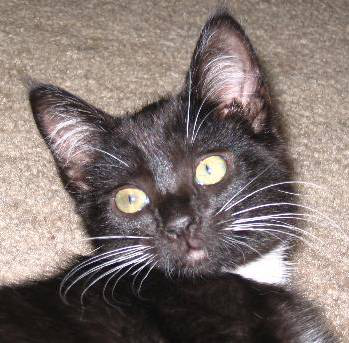

In [20]:
from PIL import Image

Image.open('train/cat.102.jpg')

In [21]:
import glob

train = pd.DataFrame({'path' : glob.glob('train/*')})
train.head()

,path
0,train/cat.0.jpg
1,train/cat.1.jpg
2,train/cat.10.jpg
3,train/cat.100.jpg
4,train/cat.1000.jpg


In [30]:
#train['path'] = train[train['path'].str.replace('\\','/')]

a = train['path'].apply(lambda x: x.split('/')[1])
a

0           cat.0.jpg
1           cat.1.jpg
2          cat.10.jpg
3         cat.100.jpg
4        cat.1000.jpg
             ...     
24995    dog.9995.jpg
24996    dog.9996.jpg
24997    dog.9997.jpg
24998    dog.9998.jpg
24999    dog.9999.jpg
Name: path, Length: 25000, dtype: object

In [32]:
train['target'] = train['path'].apply(lambda x: x.split('/')[1].split('.')[0])

In [33]:
train.head()

,path,target
0,train/cat.0.jpg,cat
1,train/cat.1.jpg,cat
2,train/cat.10.jpg,cat
3,train/cat.100.jpg,cat
4,train/cat.1000.jpg,cat


In [34]:
# make a copy
train_df = train.copy()

# shuffle the DataFrame rows randomly, so the cats and dogs rows will mixup to help us during data splitting
train_df = train_df.sample(frac = 1)

In [35]:
# Convert to spring
train_df = train_df.convert_dtypes(convert_string=True)
train_df.head()

,path,target
14481,train/dog.11780.jpg,dog
12740,train/dog.10212.jpg,dog
12248,train/cat.9772.jpg,cat
18819,train/dog.4435.jpg,dog
8834,train/cat.67.jpg,cat


In [36]:
# Feature extraction for all the pics

features_train = []
#folder = "./train/"

for path in train_df['path']:
    img2 = get_image(path)
    fe_mod.forward(Batch([mx.nd.array(img2)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    features_train.append(features)
    
len(features_train)    

25000

In [37]:
# convert the target column to binary
targetReplace = {"target": {"cat": 0, "dog": 1}}
train_df.replace(targetReplace, inplace=True)

train_df.head()

,path,target
14481,train/dog.11780.jpg,1
12740,train/dog.10212.jpg,1
12248,train/cat.9772.jpg,0
18819,train/dog.4435.jpg,1
8834,train/cat.67.jpg,0


In [38]:
# Extract features for N = 10 - 12500 (images)

features_train_N10 = features_train[:10]
features_train_N100 = features_train[:100]
features_train_N500 = features_train[:500]
features_train_N1000 = features_train[:1000]
features_train_N5000 = features_train[:5000]
features_train_N12500 = features_train[:12500]


target_N10 = train_df['target'].head(10)
target_N100 = train_df['target'].head(100)
target_N500 = train_df['target'].head(500)
target_N1000 = train_df['target'].head(1000)
target_N5000 = train_df['target'].head(5000)
target_N12500 = train_df['target'].head(12500)

In [39]:
# Our library for scaling 

class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, y=0, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, y=0, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        #X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        #if len(X.shape) >= 2:
            #X = X.reshape(-1, *self._orig_shape)
        return X

In [40]:
sample_number = []
score_results = []
time_results = []
time_results_min = []


In [41]:
#####  N = 10 #####
####################

sample_number.append(10)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N10, target_N10, test_size=0.3, random_state=42, stratify = target_N10)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.67
--- 1.3111388683319092 seconds ---


In [42]:
#####  N = 100 #####
####################

sample_number.append(100)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N100, target_N100, test_size=0.3, random_state=42, stratify = target_N100)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.53
--- 0.4566154479980469 seconds ---


In [43]:
#####  N = 500 #####
####################

sample_number.append(500)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N500, target_N500, test_size=0.3, random_state=42, stratify = target_N500)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.67
--- 1.4023962020874023 seconds ---


In [44]:
#####  N = 1000 #####
####################

sample_number.append(1000)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N1000, target_N1000, test_size=0.3, random_state=42, stratify = target_N1000)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.64
--- 3.270097494125366 seconds ---


In [45]:
#####  N = 5000 #####
####################

sample_number.append(5000)


#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N5000, target_N5000, test_size=0.3, random_state=42, stratify = target_N5000)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.76
--- 66.01011967658997 seconds ---


In [46]:
#####  N = 12500 #####
####################

sample_number.append(12500)


#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N12500, target_N12500, test_size=0.3, random_state=42, stratify = target_N12500)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.79
--- 622.7041838169098 seconds ---


In [47]:
result = pd.DataFrame({'Sample_Num':sample_number,'Accuracy':score_results,'Time(sec)':time_results, 'Time(min)':time_results_min})
result

,Sample_Num,Accuracy,Time(sec),Time(min)
0,10,0.67,1.31,0.02
1,100,0.53,0.46,0.01
2,500,0.67,1.40,0.02
3,1000,0.64,3.27,0.05
4,5000,0.76,66.01,1.10
5,12500,0.79,622.70,10.38


In [48]:
#### --- Let's also try using another pre-trained model and then compare the results

# Task 2

Use MobileNet

In [49]:
sym, arg_params, aux_params = mx.model.load_checkpoint('mobilenet_v2', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

NameError: name 'labels' is not defined

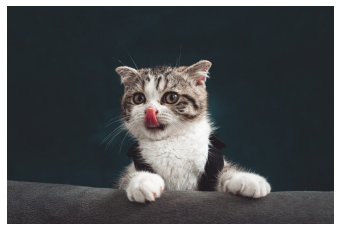

In [50]:
# test it

predict('cat-6723256_960_720.jpg')

FEATURE EXTRACTION

In [51]:
# list the last 10 layers

all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['conv6_4_bn_moving_var',
 'conv6_4_bn_output',
 'relu6_4_output',
 'pool6_output',
 'fc7_weight',
 'fc7_bias',
 'fc7_output',
 'fc7_flatten_output',
 'prob_label',
 'prob_output']

In [52]:
# An often used layer for feature extraction is the one before the last fully connected layer. 
# For for our case, it is the flattened layer with name flatten0_output

fe_sym = all_layers['fc7_flatten_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)



# We can now invoke forward to obtain the features:
imageload = 'cat-6723256_960_720.jpg' # test on one pics
#imageload = os.path.basename(imageload)
img = get_image(imageload)
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()

assert features.shape == (1, 1000), "feature is not 1000 elements"
print (features.shape)
print ('\n')


(1, 1000)




In [53]:
# Feature extraction for all the pics

features_train = []
#folder = "./train/"

for path in train_df['path']:
    img2 = get_image(path)
    fe_mod.forward(Batch([mx.nd.array(img2)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    features_train.append(features)
    
len(features_train)

25000

In [54]:
# Extract features for N = 10 - 12500 (images)

features_train_N10 = features_train[:10]
features_train_N100 = features_train[:100]
features_train_N500 = features_train[:500]
features_train_N1000 = features_train[:1000]
features_train_N5000 = features_train[:5000]
features_train_N12500 = features_train[:12500]


target_N10 = train_df['target'].head(10)
target_N100 = train_df['target'].head(100)
target_N500 = train_df['target'].head(500)
target_N1000 = train_df['target'].head(1000)
target_N5000 = train_df['target'].head(5000)
target_N12500 = train_df['target'].head(12500)

In [55]:
sample_number = []
score_results = []
time_results = []
time_results_min = []

In [56]:
#####  N = 10 #####
####################

sample_number.append(10)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N10, target_N10, test_size=0.3, random_state=42, stratify = target_N10)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.67
--- 1.1417653560638428 seconds ---


In [57]:

#####  N = 100 #####
####################

sample_number.append(100)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N100, target_N100, test_size=0.3, random_state=42, stratify = target_N100)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.63
--- 0.4349679946899414 seconds ---


In [58]:
#####  N = 500 #####
####################

sample_number.append(500)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N500, target_N500, test_size=0.3, random_state=42, stratify = target_N500)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))


Test set score: 0.58
--- 1.4834015369415283 seconds ---


In [59]:
#####  N = 1000 #####
####################

sample_number.append(1000)

#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N1000, target_N1000, test_size=0.3, random_state=42, stratify = target_N1000)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.58
--- 2.92960524559021 seconds ---


In [60]:
#####  N = 5000 #####
####################

sample_number.append(5000)


#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N5000, target_N5000, test_size=0.3, random_state=42, stratify = target_N5000)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))


Test set score: 0.61
--- 67.38727593421936 seconds ---


In [61]:
#####  N = 12500 #####
####################

sample_number.append(12500)


#split data
X_train, X_test, y_train, y_test = train_test_split(features_train_N12500, target_N12500, test_size=0.3, random_state=42, stratify = target_N12500)


# build pipeline, param, gridsearch and fit
start_time = time.time()

pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)


sc = grid.score(X_test, y_test)

score_results.append(round(sc,2))
print("Test set score: {:.2f}".format(sc))

tm = time.time() - start_time
time_results.append(round(tm,2))
tmin = round((tm/60), 2)
time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))

Test set score: 0.62
--- 449.2976689338684 seconds ---


In [62]:
result2 = pd.DataFrame({'Sample_Num':sample_number,'Accuracy':score_results,'Time(sec)':time_results, 'Time(min)':time_results_min})


In [63]:
print ("")
print("=========== SqueezeNet Results =============")
result


=========== SqueezeNet Results =============


,Sample_Num,Accuracy,Time(sec),Time(min)
0,10,0.67,1.31,0.02
1,100,0.53,0.46,0.01
2,500,0.67,1.40,0.02
3,1000,0.64,3.27,0.05
4,5000,0.76,66.01,1.10
5,12500,0.79,622.70,10.38


In [64]:
print ("")
print("=========== MobileNet Results ===========")
result2


=========== MobileNet Results ===========


,Sample_Num,Accuracy,Time(sec),Time(min)
0,10,0.67,1.14,0.02
1,100,0.63,0.43,0.01
2,500,0.58,1.48,0.02
3,1000,0.58,2.93,0.05
4,5000,0.61,67.39,1.12
5,12500,0.62,449.30,7.49


OBSERVATION:
1. SqueezeNet V2 has about same accuracies at lower sample numbers
2. They both do better at higher sample numbers
3. But SqueezeNet does the best at higher sample number
4. And the times are about the same but squeezenet takes slightly more time for the best accuracy and higher sample number 

# Task 3

In [65]:
import os

# Read data
metadata_df = pd.read_csv('Chest_xray_Corona_Metadata.csv')
metadata_df.head(2)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN


In [66]:
# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

In [67]:
train_df.head(2)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN


In [68]:
test_df.head(2)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,5309,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN
1,5310,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN


In [69]:
# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')


Shape of train data: (5286, 6)
Shape of test data: (624, 6)


In [70]:
train_df = train_df.drop(labels=["Dataset_type","Label_2_Virus_category","Label_1_Virus_category"], axis=1)
test_df = test_df.drop(labels=["Dataset_type","Label_2_Virus_category","Label_1_Virus_category"], axis=1)

In [71]:
# shuffle the DataFrame rows randomly, so the cats and dogs rows will mixup to help us during data splitting

#train_df = train_df.sample(frac = 1)
#test_df = test_df.sample(frac = 1)

# Convert to spring
train_df = train_df.convert_dtypes(convert_string=True)
test_df = test_df.convert_dtypes(convert_string=True)

In [72]:
train_df.head()

,Unnamed: 0,X_ray_image_name,Label
0,0,IM-0128-0001.jpeg,Normal
1,1,IM-0127-0001.jpeg,Normal
2,2,IM-0125-0001.jpeg,Normal
3,3,IM-0122-0001.jpeg,Normal
4,4,IM-0119-0001.jpeg,Normal


In [73]:
# Let's use sqeezenet to extract our features

sym, arg_params, aux_params = mx.model.load_checkpoint('model', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'dropout0_output',
 'conv10_conv_weight',
 'conv10_conv_bias',
 'conv10_conv_output',
 'conv10_relu_output',
 'pool10_output',
 'flatten0_output',
 'softmax_label',
 'softmax_output']

In [74]:
# using the flatten layer to extract features

fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

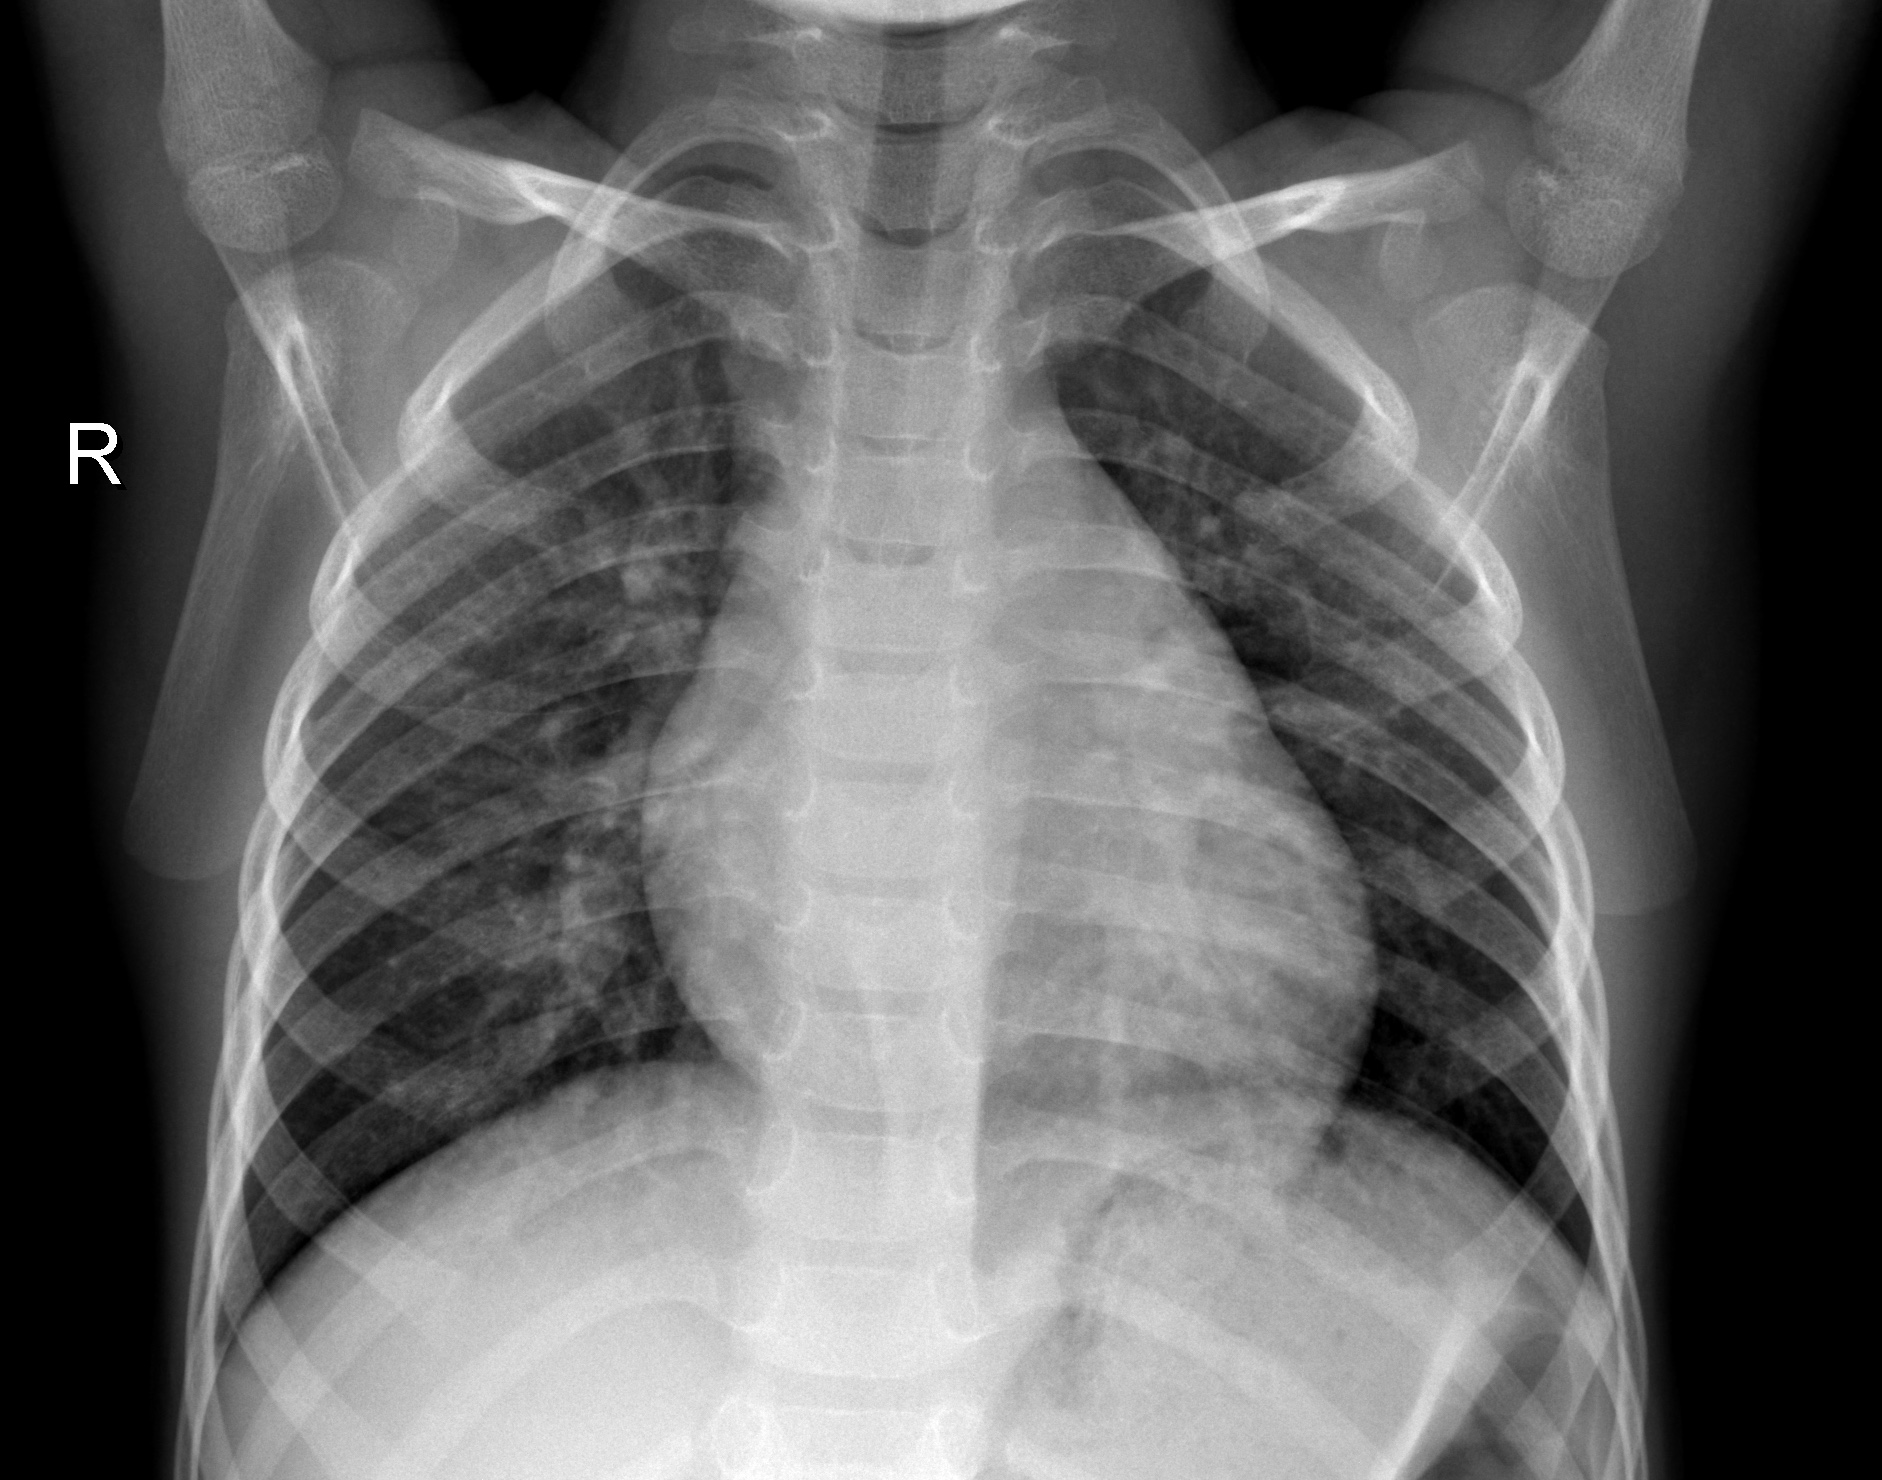

In [75]:
# just to be sure we are treating the right image files

Image.open('train2/NORMAL2-IM-0383-0001.jpeg')
#Image.open('test2/person66_virus_125.jpeg')

In [76]:
# Feature extraction for train images

features_train2 = []
folder = "train2/"

for xray in train_df['X_ray_image_name']:
    img2 = get_image(folder + xray)
    fe_mod.forward(Batch([mx.nd.array(img2)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    features_train2.append(features)
    
len(features_train2)    

5286

In [77]:
# Feature extraction for test images

features_test2 = []
folder = "test2/"

for xray in test_df['X_ray_image_name']:
    img2 = get_image(folder + xray)
    fe_mod.forward(Batch([mx.nd.array(img2)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    features_test2.append(features)
    
len(features_test2) 

624

In [79]:
# The count of the classes which shows imbalance
train_df['Label'].value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: Int64

In [80]:
# convert the target column to binary
targetReplace = {"Label": {"Normal": 0, "Pnemonia": 1}}
train_df.replace(targetReplace, inplace=True)

test_df.replace(targetReplace, inplace=True)

train_df.head(3)

,Unnamed: 0,X_ray_image_name,Label
0,0,IM-0128-0001.jpeg,0
1,1,IM-0127-0001.jpeg,0
2,2,IM-0125-0001.jpeg,0


In [81]:
# Train and fitting the model on the image data

Label = train_df['Label']

#split data
X_train, X_val, y_train, y_val = train_test_split(features_train2, Label, test_size=0.3, shuffle=True, random_state=42)


# build pipeline, param, gridsearch and fit


pipe = Pipeline([("scaler", NDStandardScaler()), ("svm", SVC())])

param_grid = {'svm__C': [0.01, 0.1, 1, 10],
             'svm__gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)


start_time = time.time() # rapping the fit around with the time "vault", time start

grid.fit(X_train, y_train)

tm = time.time() - start_time  # time stop


sc = grid.score(X_val, y_val)

print("Validation set score: {:.2f}".format(sc))


#time_results.append(round(tm,2))
tmin = round((tm/60), 2)
#time_results_min.append(tmin)
print("--- %s seconds ---" % (tm))
print(" The time also in minutes: "+ str(tmin))

Validation set score: 0.73
--- 217.7139208316803 seconds ---
 The time also in minutes: 3.63


In [85]:
# Let see model accuracy on predictions


testLabel = test_df['Label']

yhat = grid.predict(features_test2)
acc = accuracy_score(testLabel, yhat)

print("Model accuracy on the test data is: {:.2f}".format(acc))

Model accuracy on the test data is: 0.63


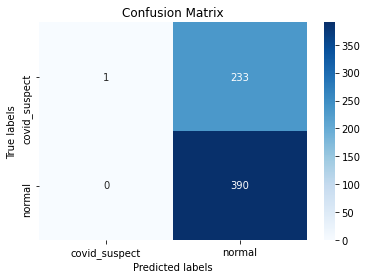

In [86]:
#Confusion Matrix of Model

def plot_confusion_matrix(y,y_predict):
    #Function to easily plot confusion matrix
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot(1,1,1)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues');
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['covid_suspect', 'normal']); ax.yaxis.set_ticklabels(['covid_suspect', 'normal'])


plot_confusion_matrix(testLabel, yhat)

In [87]:
# And running the confusion matrix somewhat manually still confirms this.

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testLabel, yhat)

TN, FP, FN, TP = confusion_matrix(testLabel, yhat).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  390
False Positive(FP) =  233
True Negative(TN)  =  1
False Negative(FN) =  0
Accuracy of the binary classification = 0.627


OBSERVATION:
1. Our model looks to be average, but medically it performs abysmally poor, since it miss-classified 233 (it says they were normal but they actually have pneumonia and as such a covid suspect)
2. And by the way, it only correctly predicted just one covid suspect case.
3. Perhaps we need some data augmentation, since the data was imbalance.